<h2><center>Spherical Harmonics Properties</center></h2>

This notebook collects and validates various SH properties:

Orthognality:

$$
\int_{S^2} Y^{l_1m_1}\left(\omega\right) \overline{Y^{l_2m_2}}\left(\omega\right) \mathbf{d}\omega_i = \delta_{l_1m_1}\delta_{l_2m_2}
$$

The product of two SH basis functions is given as:

$$
Y^{l_1m_1}\left(\omega\right)Y^{l_2m_2}\left(\omega\right) = \sum_{l}\sum_{m=-l}^{l}\sqrt{\frac{\left(2l_1+1\right)\left(2l_2+1\right)}{4\pi\left(2l+1\right)}}C_{l_10l_20}^{l0}C_{l_1m_1l_2m_2}^{lm}Y^{lm}\left(\omega\right)
$$

where $C_{l_1m_1l_2m_2}^{lm}$ are the Clebsch-Gordan coefficients.

Integral of a single SH basis function over solid angle:

$$
\int_\Omega Y^{lm}\left(\omega\right)\mathbf{d}\omega = \sqrt{4\pi}\delta_{l0}\delta_{m0}
$$


The inner product of two SH basis functions:

$$
\int_\Omega Y^{l_1m_1}\left(\omega\right)Y^{l_2 m_2}\left(\omega\right)\mathbf{d}\omega = \delta_{l_1l_2}\delta_{|m_1||m_2|}
$$




In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from scipy.special import sph_harm
import matplotlib.pyplot as plt
from sympy.physics.quantum.cg import CG, Wigner3j

# utility functions =========================================
def numSHCoeffs(order):
    return (order + 1) * (order + 1)

def shIndex( l, m):
    return l * (l + 1) + m;

def sh_sum( order, coeffs, theta, phi ):
    result = 0.0
    for l in range(order+1):
        for m in range(-l, l+1):
            result+=coeffs[shIndex(l,m)]*sph_harm(m, l, phi, theta)
    return result

def project_sh( fun, order ):
    coeffs = np.zeros(numSHCoeffs(order), dtype=complex)
    for l in range(order+1):
        for m in range(-l, l+1):
            # NB: we use the complex conjugate of the spherical harmonics function for projection
            # see https://en.wikipedia.org/wiki/Spherical_harmonics#Spherical_harmonics_expansion
            coeffs[shIndex(l,m)] = integrate_sphere( lambda theta, phi: fun(theta, phi)*np.conj(sph_harm(m, l, phi, theta)) )
    return coeffs            

def integrate_sphere( fun ):
    result = 0.0

    min_theta = 0
    max_theta = np.pi
    min_phi = 0
    max_phi = 2.0*np.pi

    resolution_theta=128 # resolution along theta angle
    resolution_phi=256 # resolution along phi angle
    dtheta = (max_theta-min_theta)/float(resolution_theta)
    dphi = (max_phi-min_phi)/float(resolution_phi)

    pixel_area = dtheta*dphi

    for t in range(resolution_theta):
        for p in range(resolution_phi):
            phi = dphi*p
            theta = dtheta*t
            result+=fun(theta, phi)*pixel_area*np.sin(theta)

    return result

def plot_spherical_function( fun, vmin=-0.5, vmax=0.5 ):
    # plot sh functions
    theta = np.arange(0.0, 1.0, 0.01)*np.pi
    phi = np.arange(0.0, 1.0, 0.01)*2.0*np.pi

    f_img = np.zeros((theta.shape[0], phi.shape[0]))
    for j in range(phi.shape[0]):
        for i in range(theta.shape[0]):
            f_img[i, j] = fun(theta[i], phi[j])
    plt.imshow(f_img, interpolation="nearest", cmap='jet', vmin=vmin, vmax=vmax)
    
# here we build a table of precomputed Clebsch-Gordan coefficients
CG_table_order = 7
CG_table = np.zeros( (numSHCoeffs(CG_table_order), numSHCoeffs(CG_table_order), numSHCoeffs(CG_table_order)) )

for l in range(CG_table_order+1):
    for m in range(-l, l+1):
        for l1 in range(CG_table_order+1):
            for m1 in range(-l1, l1+1):
                for l2 in range(CG_table_order+1):
                    for m2 in range(-l2, l2+1):
                        CG_table[shIndex(l, m), shIndex(l1, m1), shIndex(l2, m2)] = CG(l, m, l1, m1, l2, m2).doit().evalf()


------------------

### Spherical Harmonics Projection and Reconstruction

The following script is just to make sure that our projection and reconstruction is correct.

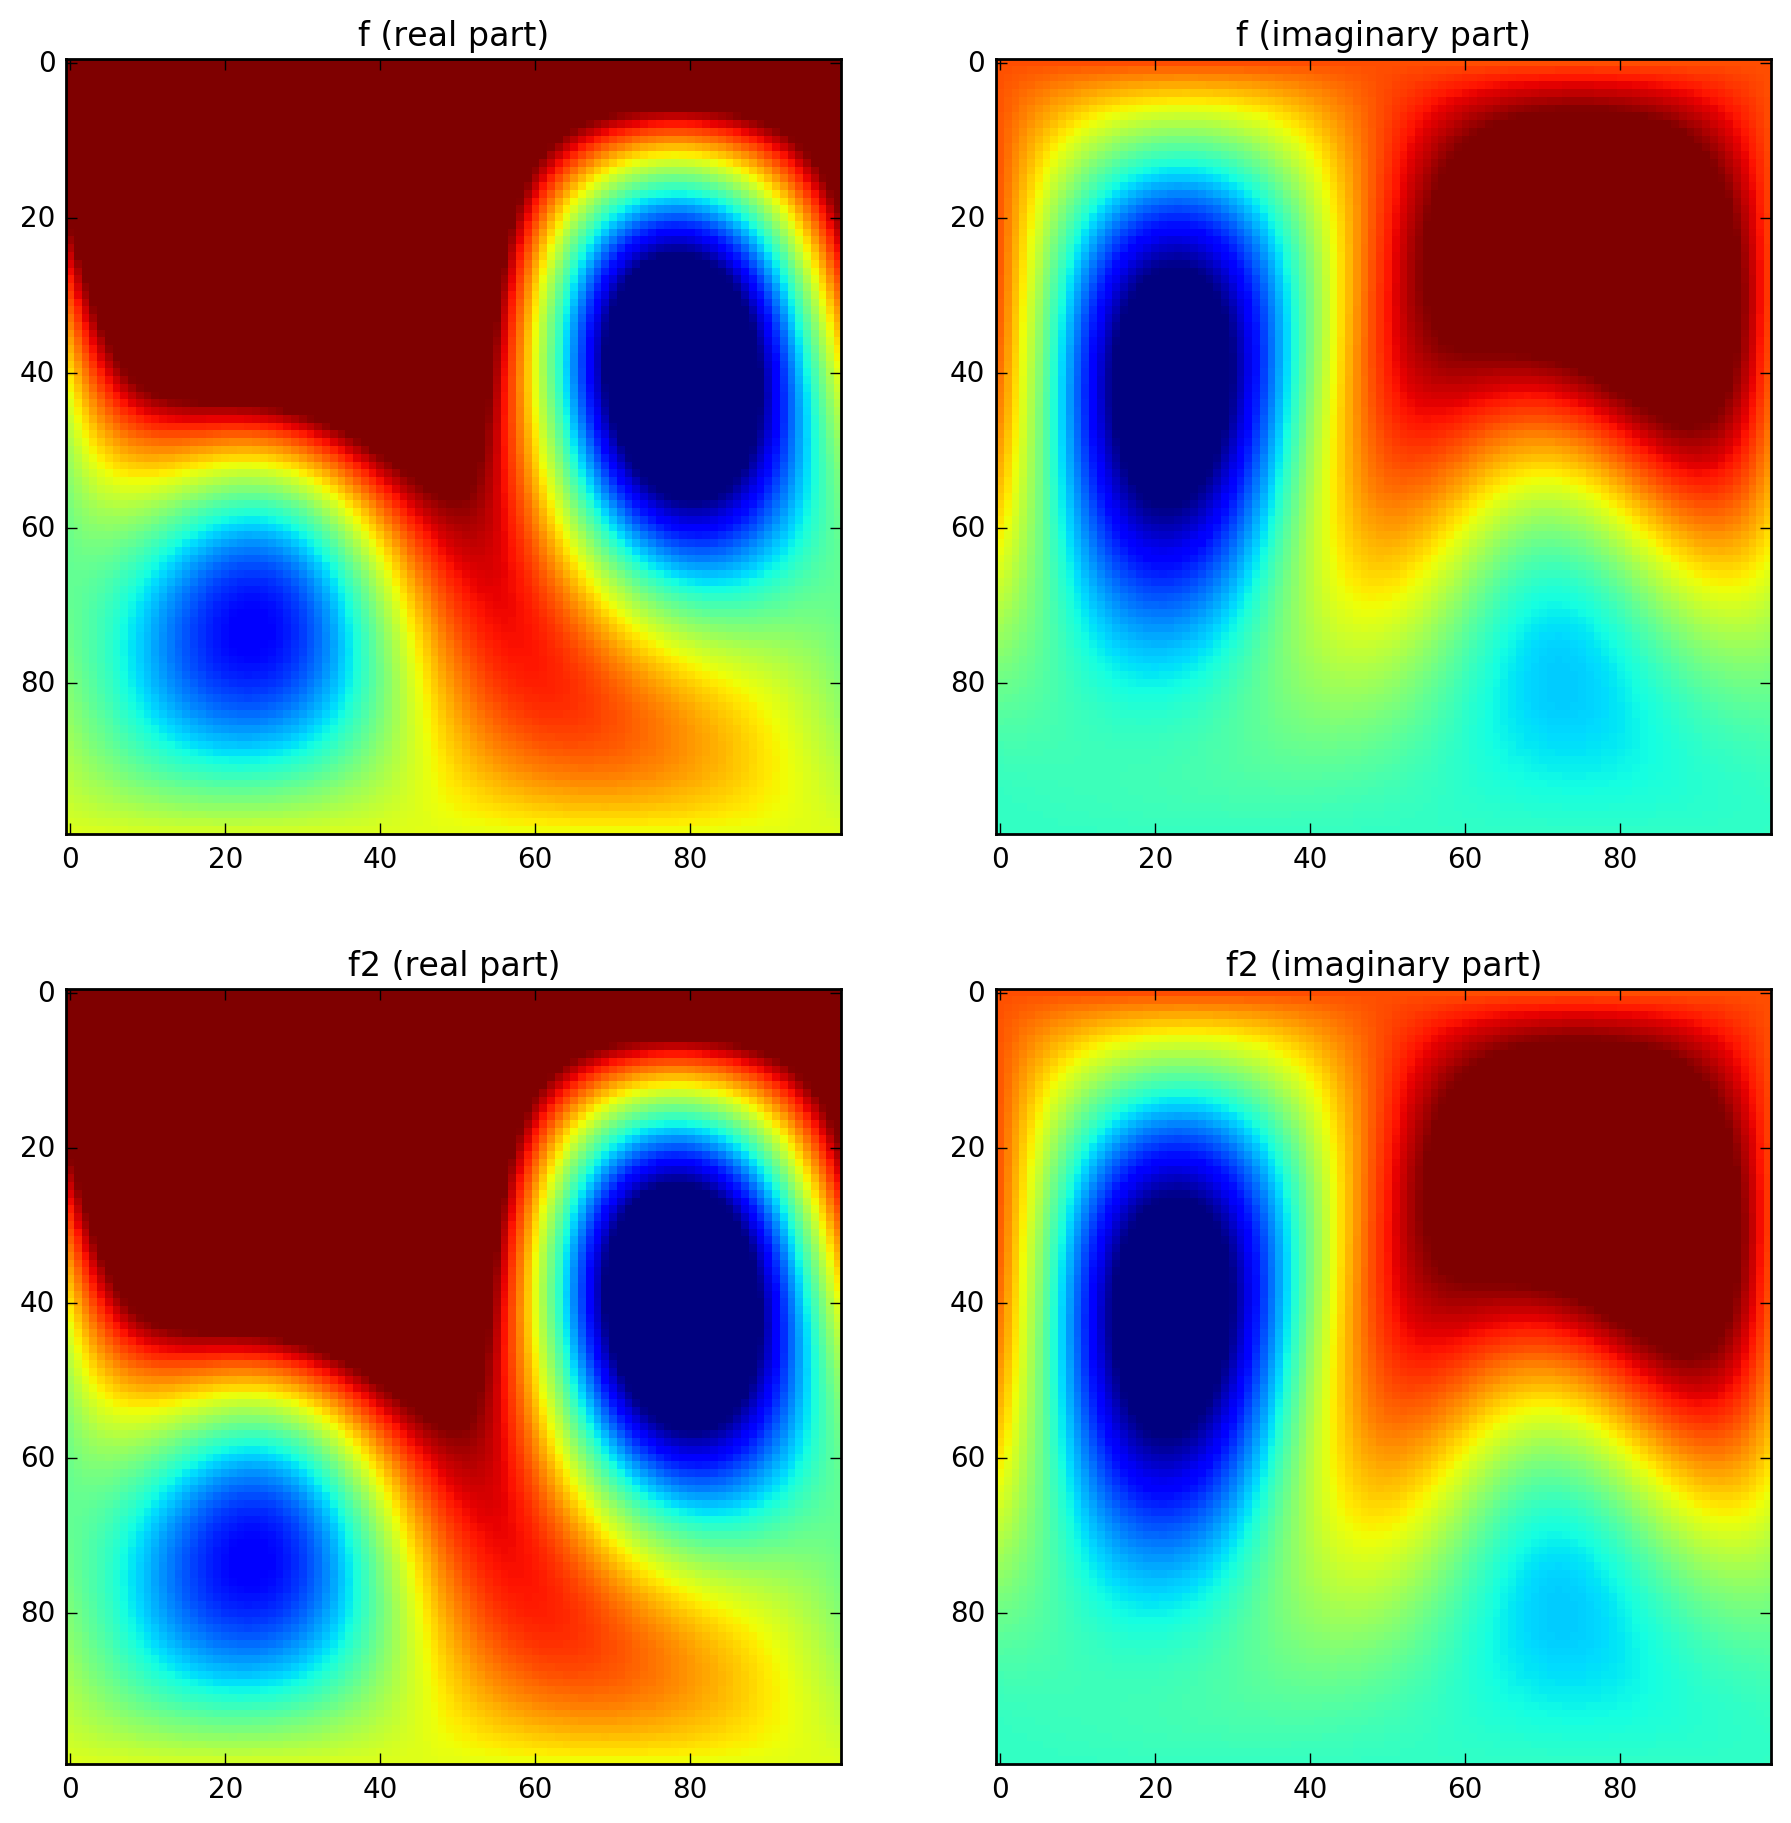

In [2]:
# here we validate that projection and reconstruction are correct
# we first project f into spherical harmonics coefficients f_lm2
# since f is defined in terms of spherical harmonics coefficients f_lm already,
# we can simply validate correctness by making sure the coefficients match
np.random.seed(123)
order = 2
f_lm = np.zeros( numSHCoeffs(order), dtype=complex )
for i in range(numSHCoeffs(order)):
    f_lm[i] = np.complex(np.random.random(), np.random.random())

def f(theta, phi):
    global f_lm
    global order
    return sh_sum(order, f_lm, theta, phi)

f_lm2 = project_sh( lambda theta, phi: f(theta, phi), order )

def f2( theta, phi ):
    global f_lm2
    global order
    return sh_sum(order, f_lm2, theta, phi)


fig = plt.figure(figsize=(11, 11))
ax = plt.subplot(221)
plt.title('f (real part)')
plot_spherical_function(lambda theta, phi: np.real(f(theta, phi)))

ax = plt.subplot(222)
plt.title('f (imaginary part)')
plot_spherical_function(lambda theta, phi: np.imag(f(theta, phi)))

ax = plt.subplot(223)
plt.title('f2 (real part)')
plot_spherical_function(lambda theta, phi: np.real(f2(theta, phi)))

ax = plt.subplot(224)
plt.title('f2 (imaginary part)')
plot_spherical_function(lambda theta, phi: np.imag(f2(theta, phi)))

plt.show()


------------------------

### Spherical Harmonics Orthogonality

One of the most important properties is orthogonality of the SH basis functions:

$$
\int_{S^2} Y^{l_1m_1}\left(\omega\right) \overline{Y^{l_2m_2}}\left(\omega\right) \mathbf{d}\omega_i = \delta_{l_1m_1}\delta_{l_2m_2}
$$

In [14]:
order = 1
for l1 in range(order+1):
    for m1 in range(-l1, l1+1):
        for l2 in range(order+1):
            for m2 in range(-l2, l2+1):
                x = integrate_sphere( lambda theta, phi: sph_harm(m1, l1, phi, theta)*np.conj(sph_harm(m2, l2, phi, theta)) )
                if np.abs(x) < 1.0e-3:
                    x = 0
                prefix = ""
                if l1==l2 and m1==m2:
                    prefix="->"
                print( "{} l1={} l2={} m1={} m2={} inner product={}".format(prefix, l1, l2, m1, m2, x) )

-> l1=0 l2=0 m1=0 m2=0 inner product=(0.999949800092179+0j)
 l1=0 l2=1 m1=0 m2=-1 inner product=0
 l1=0 l2=1 m1=0 m2=0 inner product=0
 l1=0 l2=1 m1=0 m2=1 inner product=0
 l1=1 l2=0 m1=-1 m2=0 inner product=0
-> l1=1 l2=1 m1=-1 m2=-1 inner product=(1.0000000045365718+0j)
 l1=1 l2=1 m1=-1 m2=0 inner product=0
 l1=1 l2=1 m1=-1 m2=1 inner product=0
 l1=1 l2=0 m1=0 m2=0 inner product=0
 l1=1 l2=1 m1=0 m2=-1 inner product=0
-> l1=1 l2=1 m1=0 m2=0 inner product=(0.999849391203005+0j)
 l1=1 l2=1 m1=0 m2=1 inner product=0
 l1=1 l2=0 m1=1 m2=0 inner product=0
 l1=1 l2=1 m1=1 m2=-1 inner product=0
 l1=1 l2=1 m1=1 m2=0 inner product=0
-> l1=1 l2=1 m1=1 m2=1 inner product=(1.0000000045365718+0j)


-------------------------------------

### Spherical Harmonics Product

The product of two SH basis functions is given as:

$$
Y^{l_1m_1}\left(\omega\right)Y^{l_2m_2}\left(\omega\right) = \sum_{l}\sum_{m=-l}^{l}\sqrt{\frac{\left(2l_1+1\right)\left(2l_2+1\right)}{4\pi\left(2l+1\right)}}C_{l_10l_20}^{l0}C_{l_1m_1l_2m_2}^{lm}Y^{lm}\left(\omega\right)
$$

where $C_{l_1m_1l_2m_2}^{lm}$ are the Clebsch-Gordan coefficients.

In [3]:
# this function defines the groundtruth product between two SH basis functions
def Y1Y2( theta, phi, l1, m1, l2, m2 ):
    return sph_harm(m1, l1, phi, theta)*sph_harm(m2, l2, phi, theta)

# this functions computes the product between two SH basis functions using
# see https://en.wikipedia.org/wiki/Clebsch%E2%80%93Gordan_coefficients#Relation_to_spherical_harmonics
def Y1Y2_CG( theta, phi, l1, m1, l2, m2 ):
    order = l1+l2
    result = 0.0
    for l in range(order+1):
        for m in range(-l, l+1):
            a = np.sqrt( (2.0*l1+1.0)*(2.0*l2+1.0)/(4.0*np.pi*(2.0*l+1.0)) )
            CG0 = CG_table[shIndex(l1, m1), shIndex(l2, m2), shIndex(l, m)]
            CG1 = CG_table[shIndex(l1, 0), shIndex(l2, 0), shIndex(l, 0)]
            Y = sph_harm(m, l, phi, theta)
            result+=a*CG0*CG1*Y
    return result



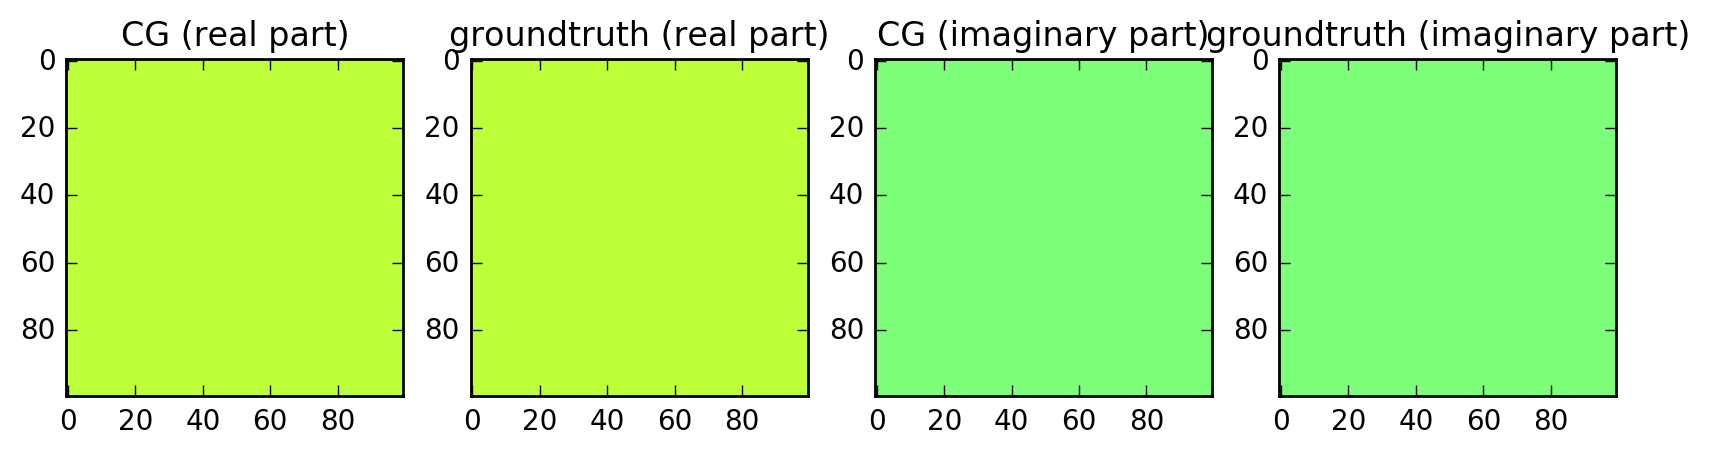

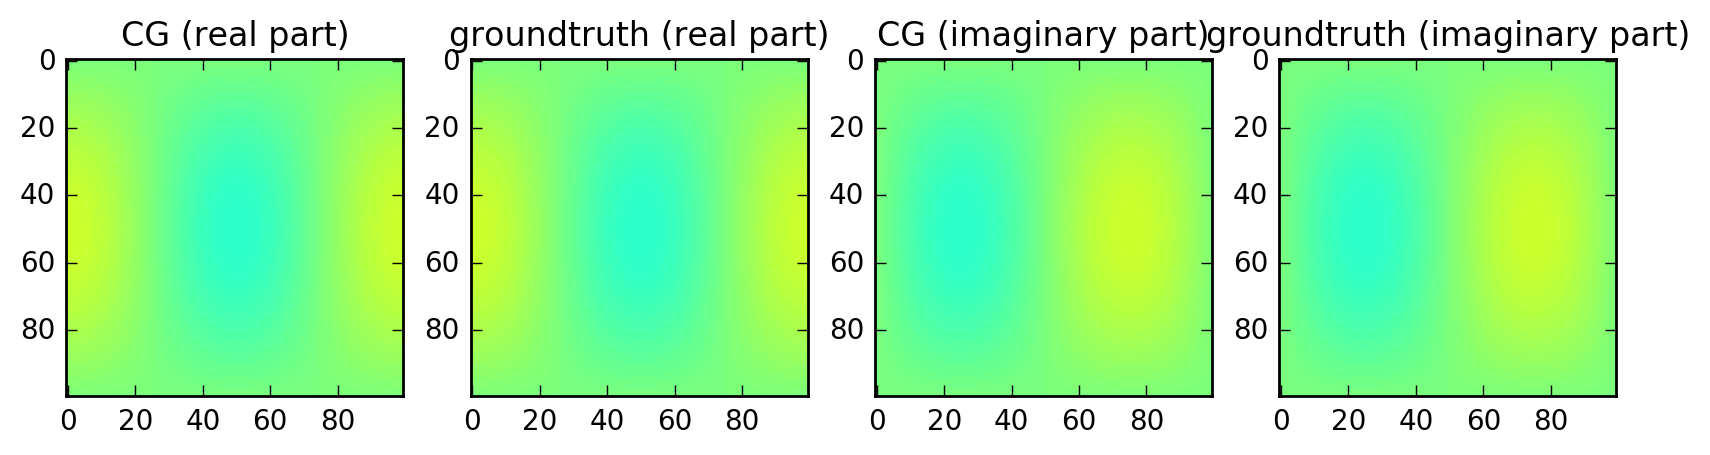

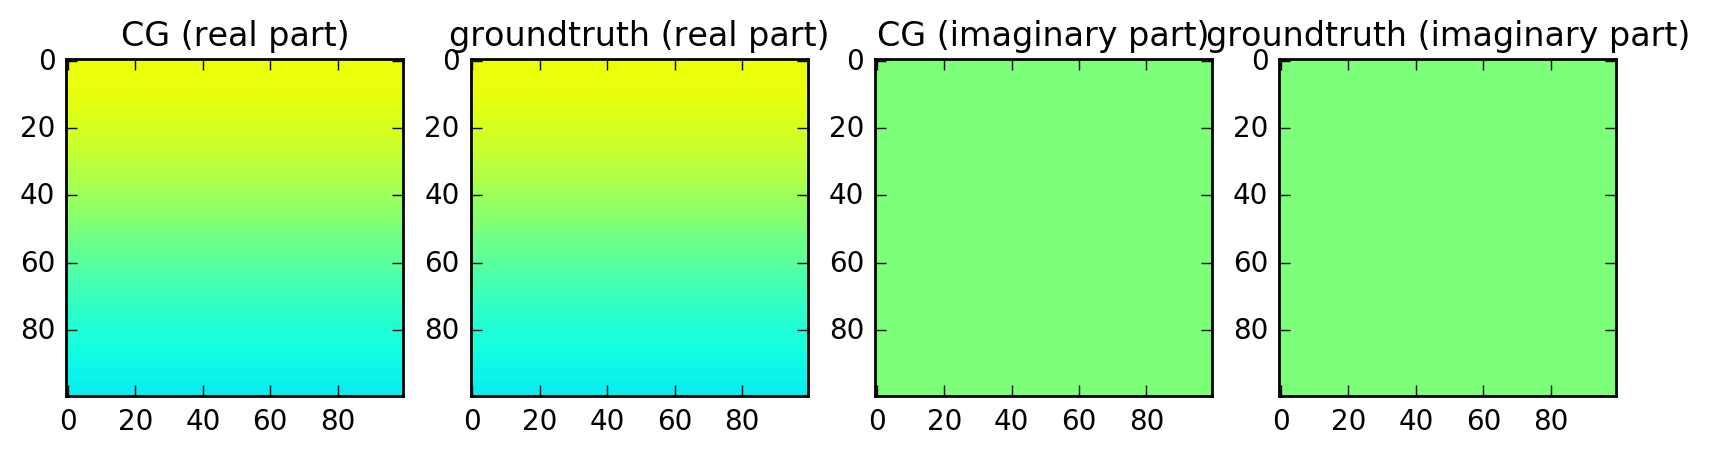

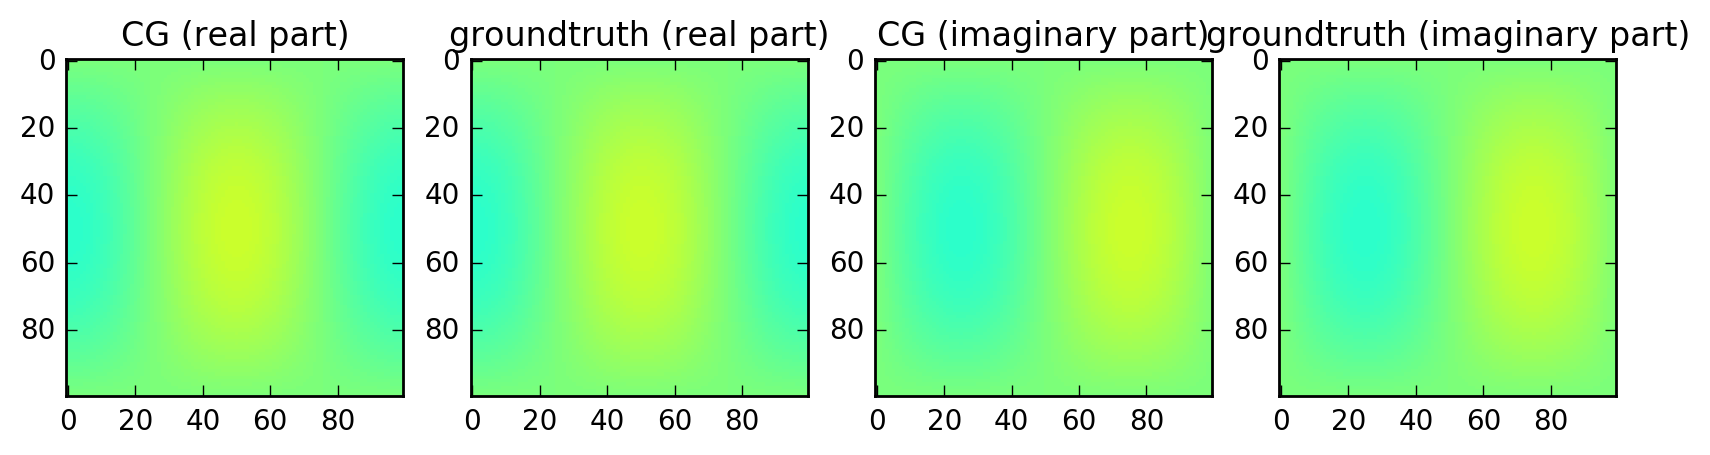

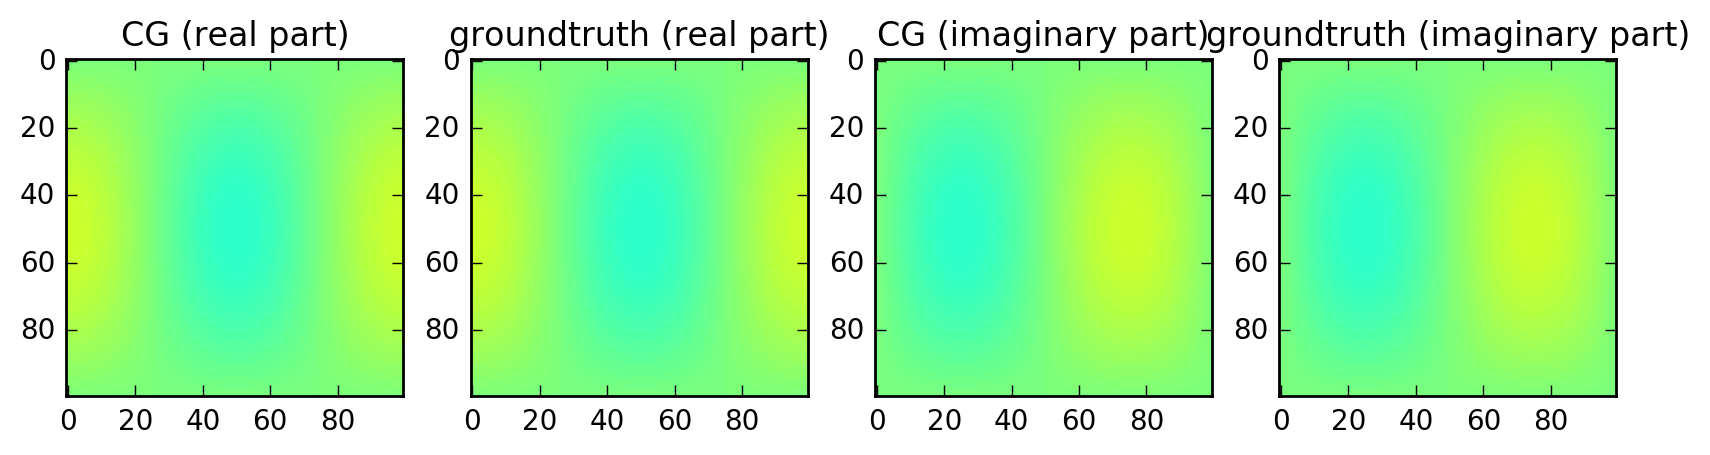

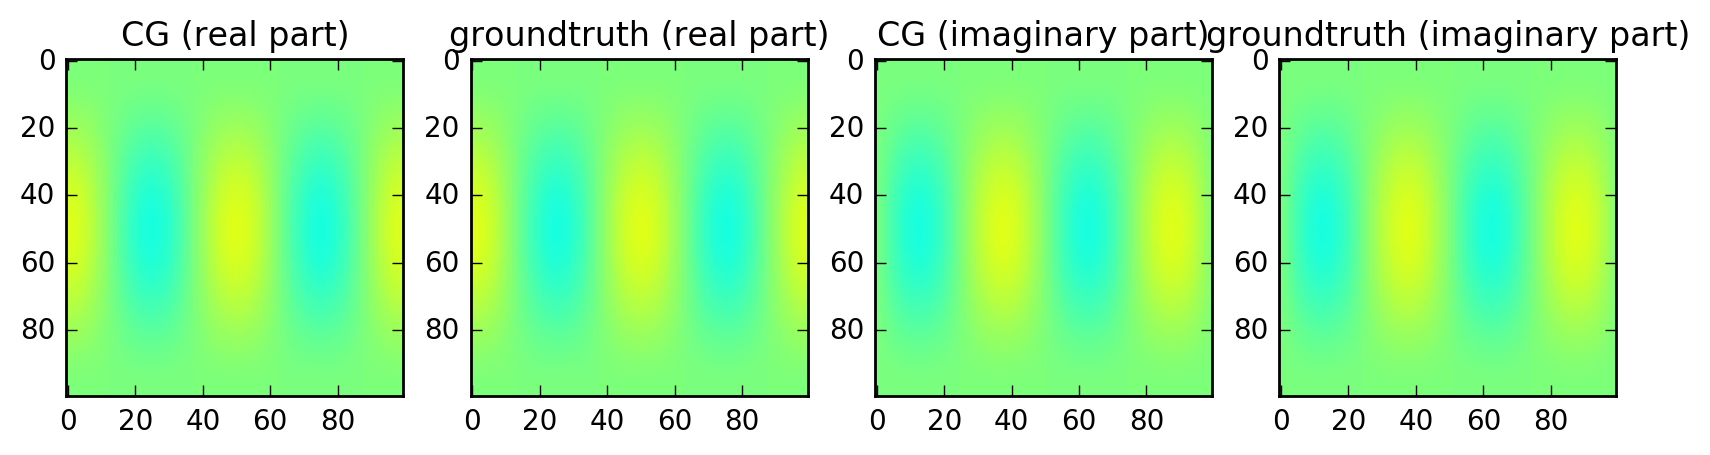

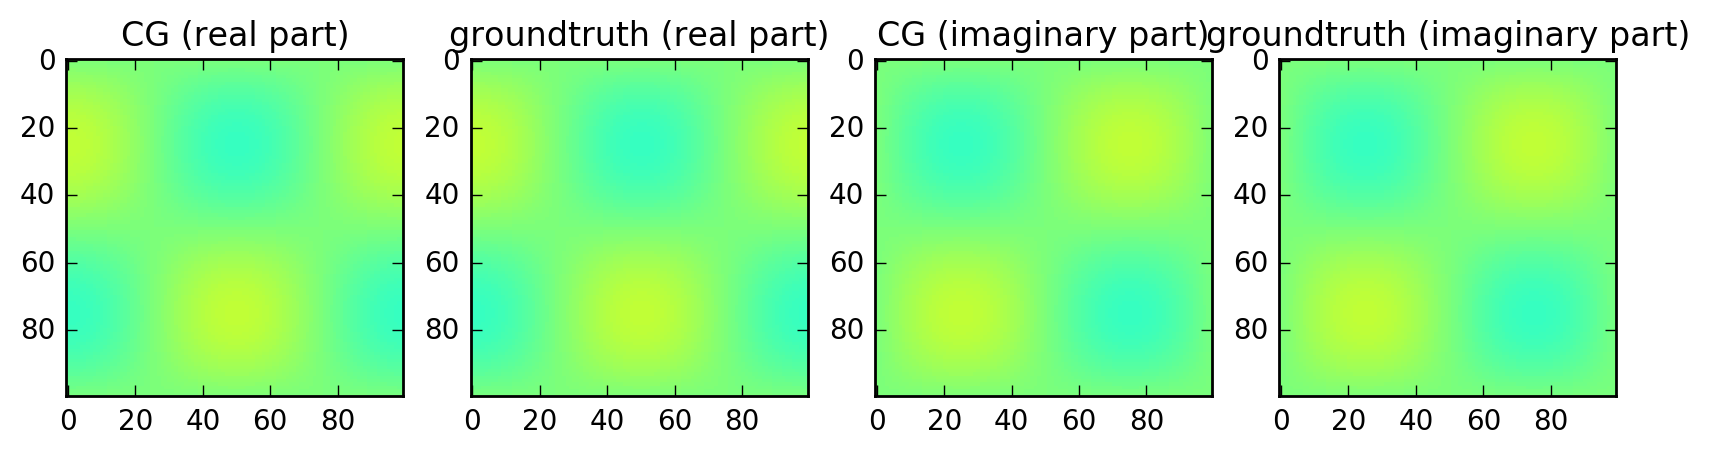

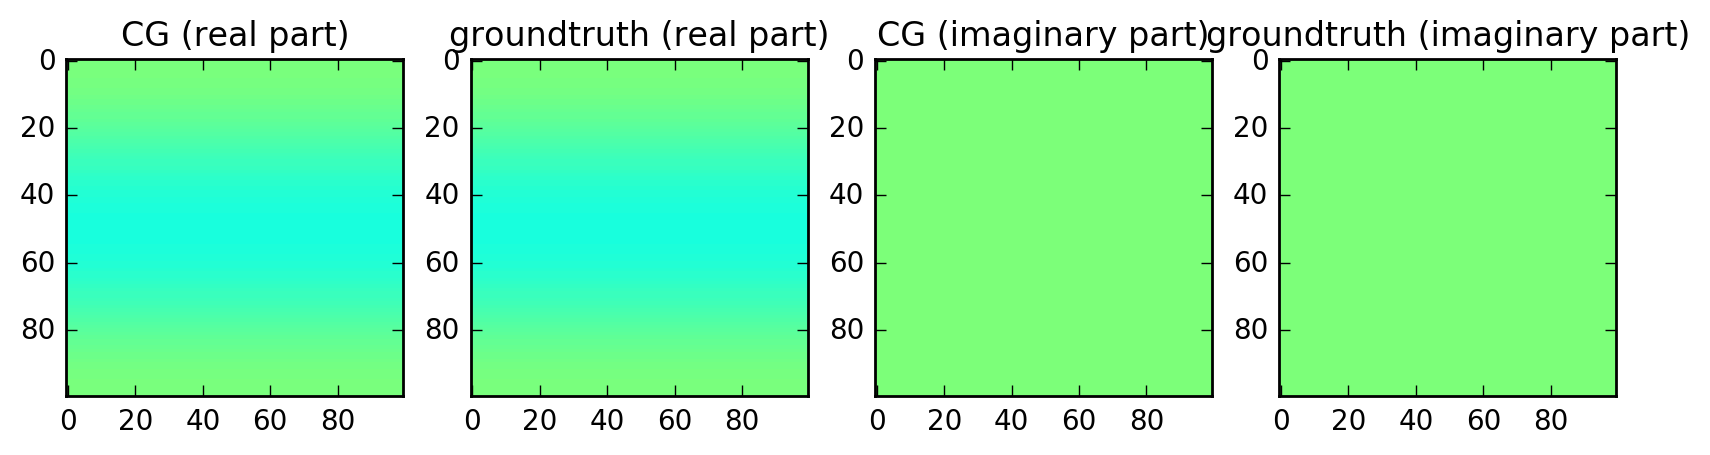

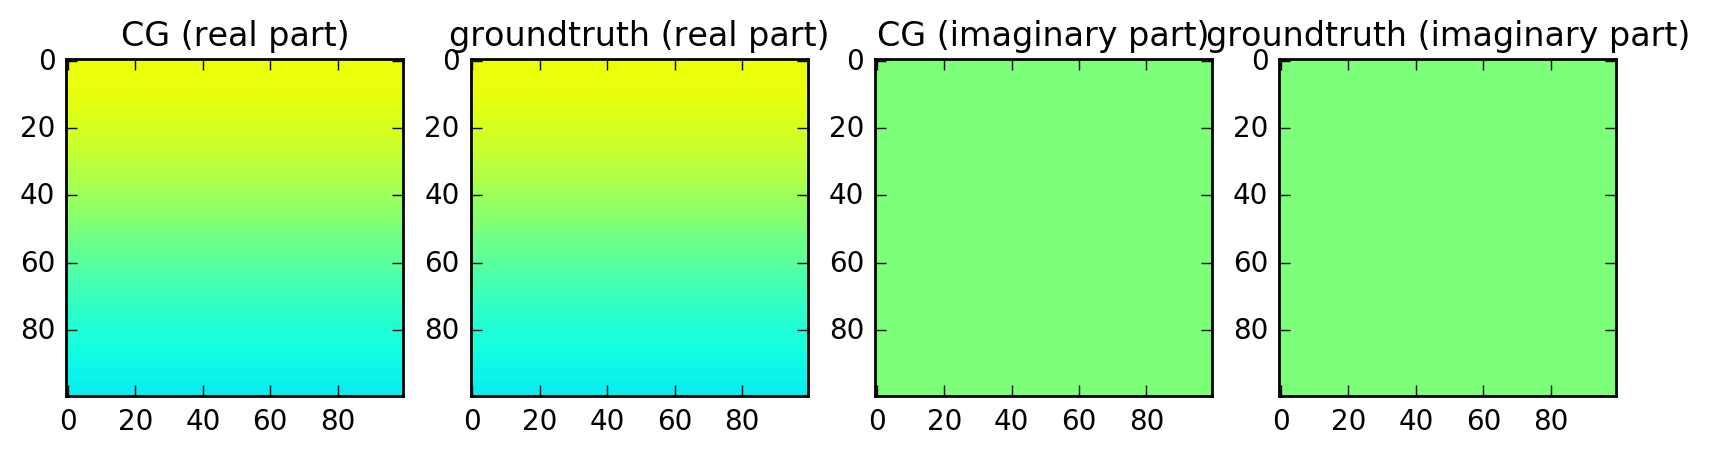

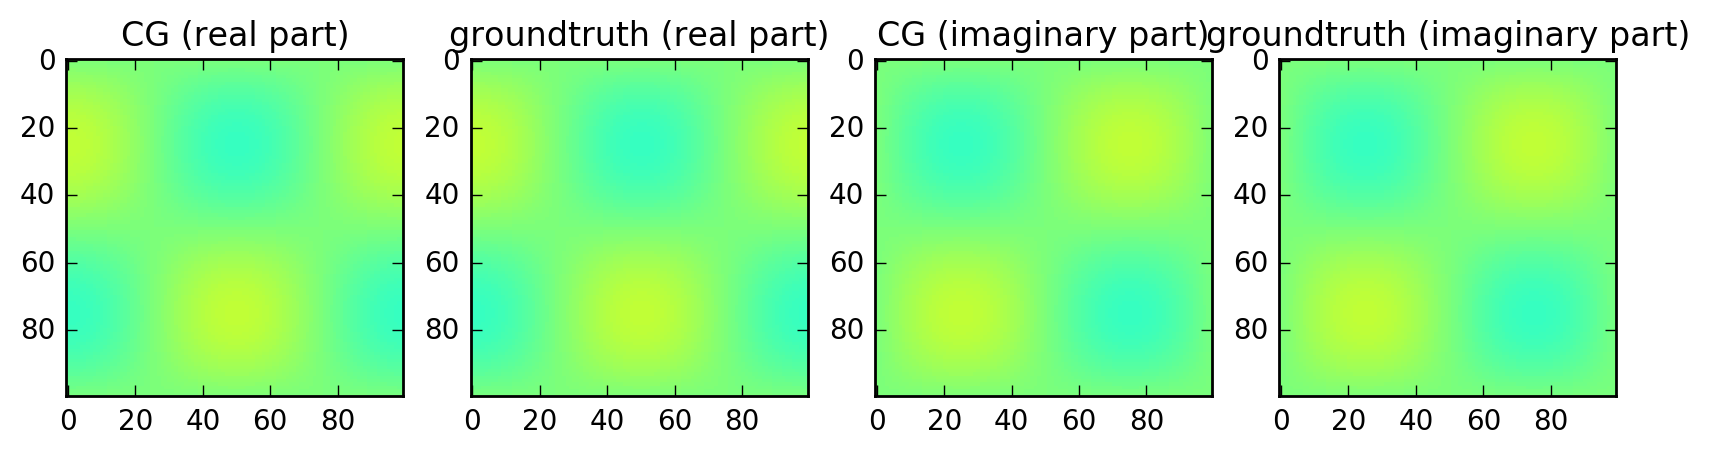

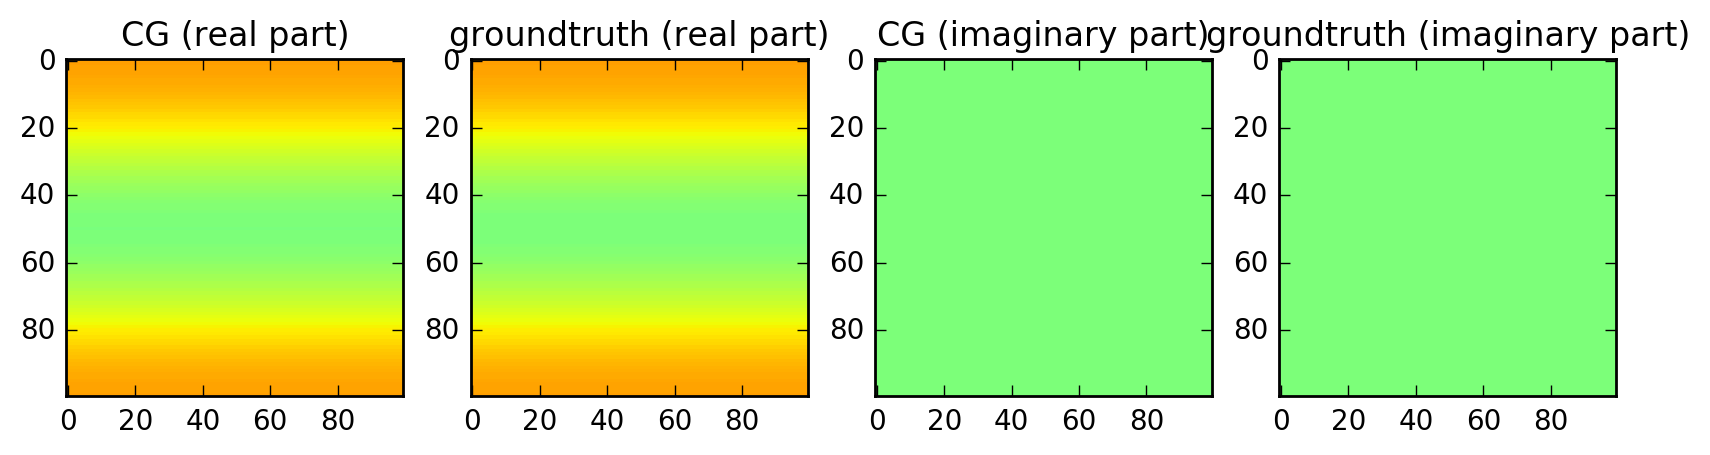

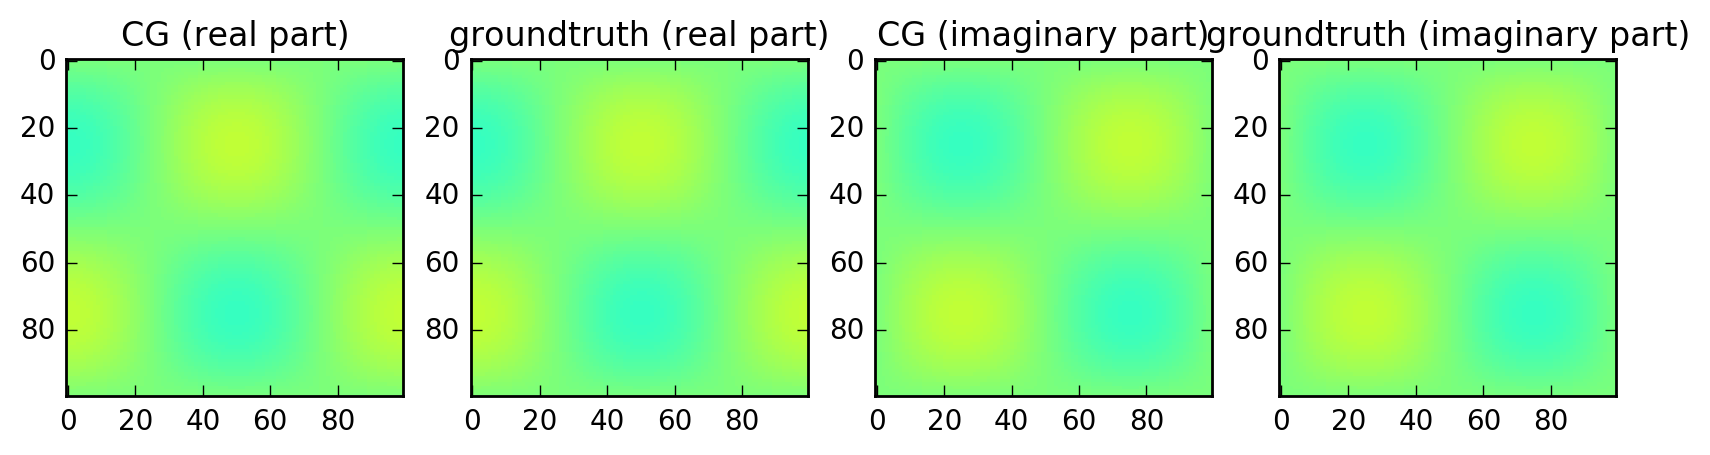

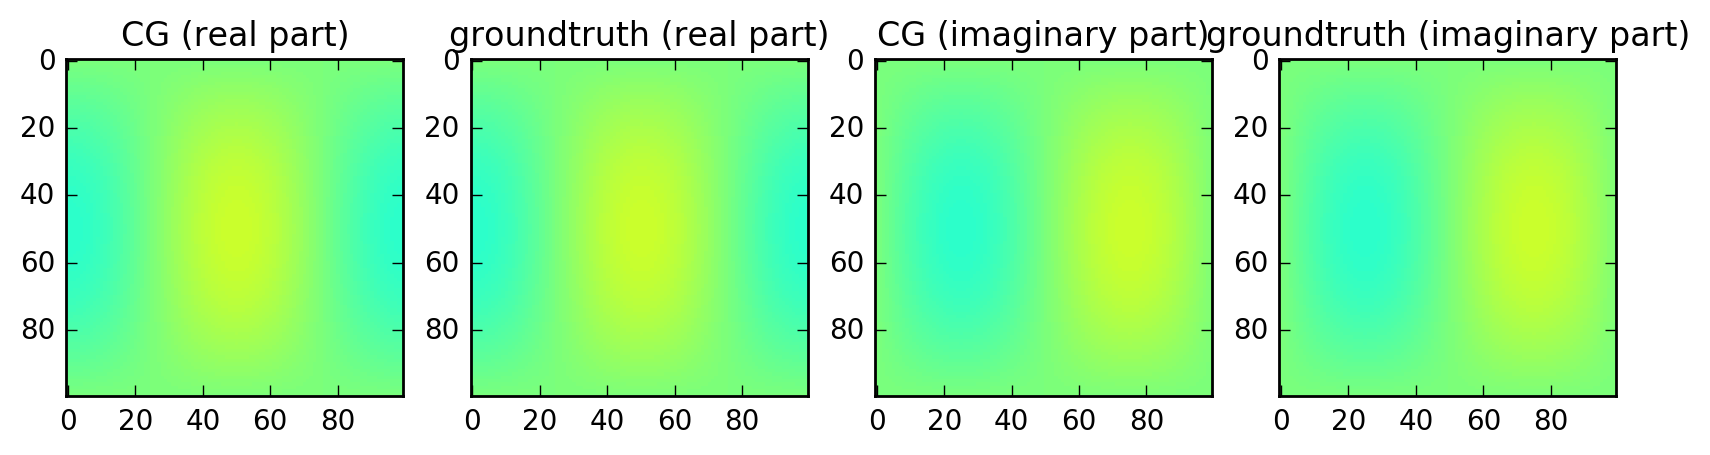

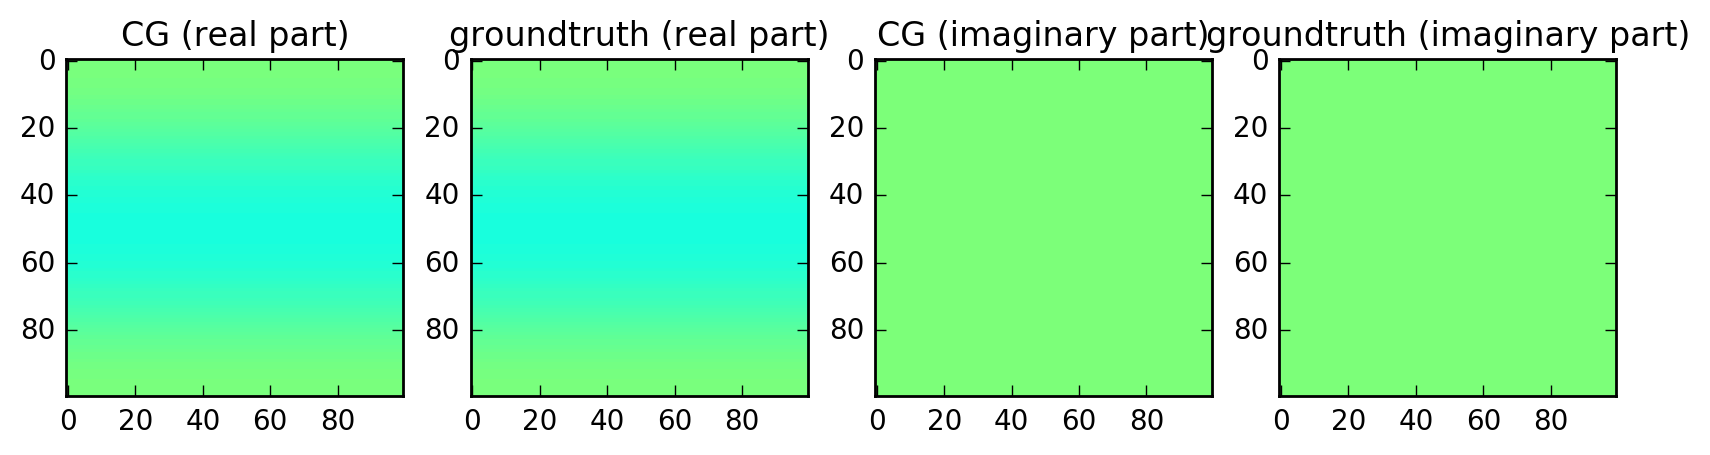

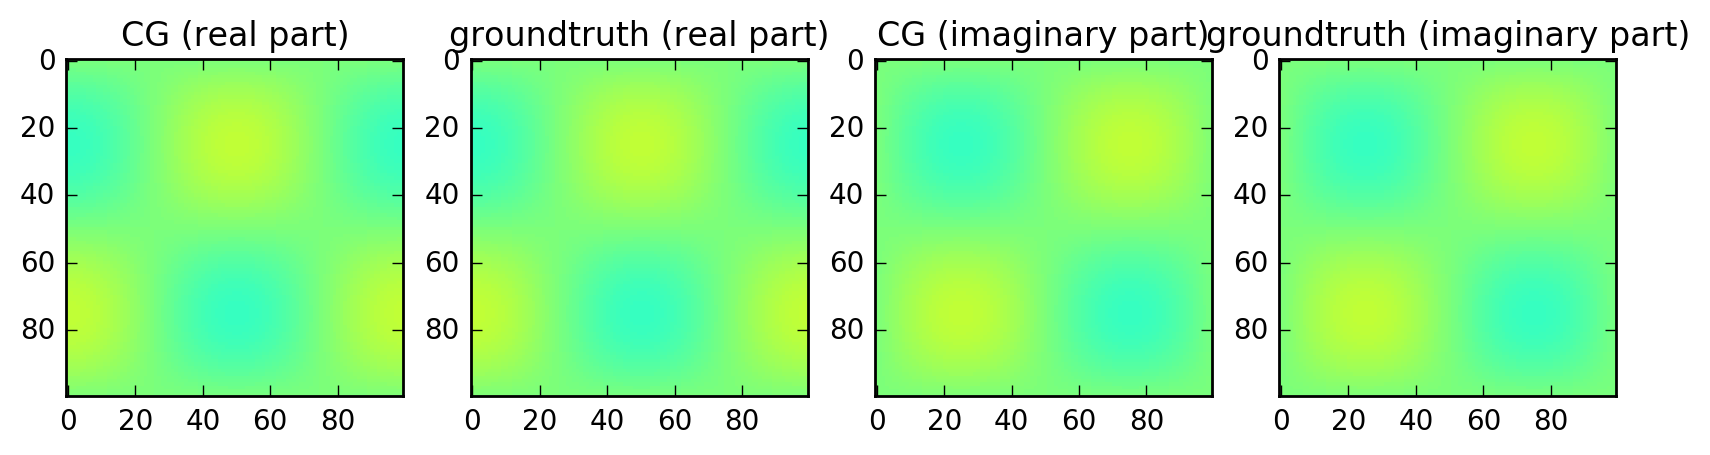

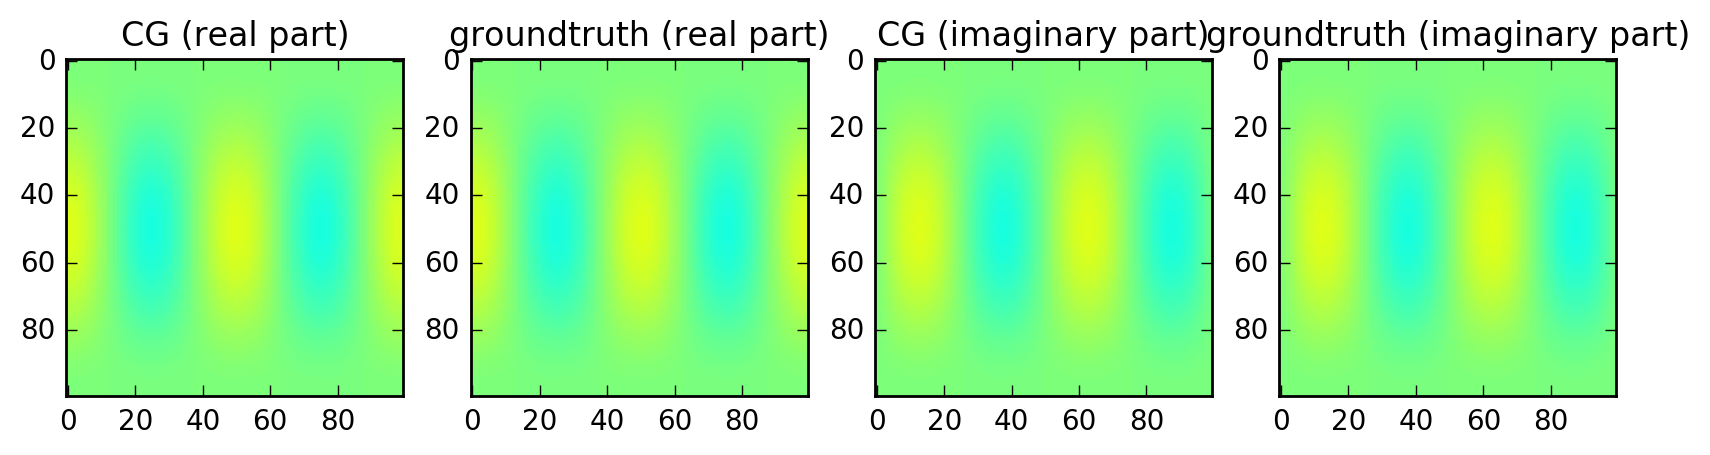

In [16]:
order_min = 0
order = 1
for l1 in range(order_min, order+1):
    for m1 in range(-l1, l1+1):
        for l2 in range(order_min, order+1):
            for m2 in range(-l2, l2+1):
                fig = plt.figure(figsize=(10, 5))
                ax = plt.subplot(141)
                plt.title('CG (real part)')
                plot_spherical_function(lambda theta, phi: np.real(Y1Y2_CG(theta, phi, l1, m1, l2, m2)))

                ax = plt.subplot(142)
                plt.title('groundtruth (real part)')
                plot_spherical_function(lambda theta, phi: np.real(Y1Y2(theta, phi, l1, m1, l2, m2)))

                ax = plt.subplot(143)
                plt.title('CG (imaginary part)')
                plot_spherical_function(lambda theta, phi: np.imag(Y1Y2_CG(theta, phi, l1, m1, l2, m2)))

                ax = plt.subplot(144)
                plt.title('groundtruth (imaginary part)')
                plot_spherical_function(lambda theta, phi: np.imag(Y1Y2(theta, phi, l1, m1, l2, m2)))

                plt.show()

-------------------------------------

### Spherical Harmonics Integral over solid angle

We want to find an expression for 

$$
\int_\Omega Y^{lm}\left(\omega\right)\mathbf{d}\omega
$$

Since we have

$$
\sqrt{4\pi}\overline{Y^{00}}\left(\omega\right) = 1
$$

we can write

$$
\begin{align}
\int_\Omega Y^{lm}\left(\omega\right)\mathbf{d}\omega &= \sqrt{4\pi}\int_\Omega Y^{lm}\left(\omega\right)\overline{Y^{00}}\left(\omega\right)\mathbf{d}\omega\\
&= \sqrt{4\pi}\delta_{l0}\delta_{m0}
\end{align}
$$


-------------------------------------

### Inner product integral of two spherical harmonics basis functions

Integral

$$
\int_\Omega Y^{l_1m_1}\left(\omega\right)Y^{l_2 m_2}\left(\omega\right)\mathbf{d}\omega\\
$$

Substituting the the SH basis product by the Clebsch-Gordan expression within the integral gives

$$
\sum_{l}\sum_{m=-l}^{l}\sqrt{\frac{\left(2l_1+1\right)\left(2l_2+1\right)}{4\pi\left(2l+1\right)}}C_{l_10l_20}^{l0}C_{l_1m_1l_2m_2}^{lm}\int_\Omega Y^{lm}\left(\omega\right)\mathbf{d}\omega
$$

Applying the identity

$$
\int_\Omega Y^{lm}\left(\omega\right)\mathbf{d}\omega = \sqrt{4\pi}\delta_{l0}\delta_{m0}
$$

results in

$$
\sqrt{\left(2l_1+1\right)\left(2l_2+1\right)}C_{l_10l_20}^{00}C_{l_1m_1l_2m_2}^{00}
$$

after studying this in python for a number of combinations, we see the following pattern:

$$
\sqrt{\left(2l_1+1\right)\left(2l_2+1\right)}C_{l_10l_20}^{00}C_{l_1m_1l_2m_2}^{00} = (-1)^{m_1}\delta_{l_1l_2}\delta_{(m_1+m_2)0}
$$



In [14]:
def intY1Y2( l1, m1, l2, m2 ):
    a = np.sqrt((2.0*l1+1.0)*(2.0*l2+1.0))
    CG0 = CG(l1, 0, l2, 0, 0, 0).doit().evalf()
    CG1 = CG(l1, m1, l2, m2, 0, 0).doit().evalf()
    return a*CG0*CG1
    

order_min = 0
order = 3

for l1 in range(order_min, order+1):
    for m1 in range(-l1, l1+1):
        for l2 in range(order_min, order+1):
            for m2 in range(-l2, l2+1):
                a = integrate_sphere( lambda theta, phi: Y1Y2(theta, phi, l1, m1, l2, m2) )
                b = intY1Y2(l1, m1, l2, m2)
                if np.abs(b)>1.0e-4:
                    print("l1={} l2={} m1={} m2={} a={} b={}".format(l1, l2, m1, m2, np.real(a), b))


l1=0 l2=0 m1=0 m2=0 a=0.999949800092179 b=1.00000000000000
l1=1 l2=1 m1=-1 m2=1 a=-1.0000000045365718 b=-1.00000000000000
l1=1 l2=1 m1=0 m2=0 a=0.999849391203005 b=1.00000000000000
l1=1 l2=1 m1=1 m2=-1 a=-1.0000000045365718 b=-1.00000000000000
l1=2 l2=2 m1=-2 m2=2 a=0.9999999999984035 b=1.00000000000000
l1=2 l2=2 m1=-1 m2=1 a=-1.0000000226896617 b=-1.00000000000000
l1=2 l2=2 m1=0 m2=0 a=0.9997489550846677 b=1.00000000000000
l1=2 l2=2 m1=1 m2=-1 a=-1.0000000226896617 b=-1.00000000000000
l1=2 l2=2 m1=2 m2=-2 a=0.9999999999984035 b=1.00000000000000
l1=3 l2=3 m1=-3 m2=3 a=-1.0000000000001599 b=-1.00000000000000
l1=3 l2=3 m1=-2 m2=2 a=0.9999999999885549 b=1.00000000000000
l1=3 l2=3 m1=-1 m2=1 a=-1.000000063558147 b=-1.00000000000000
l1=3 l2=3 m1=0 m2=0 a=0.9996484735512091 b=1.00000000000000
l1=3 l2=3 m1=1 m2=-1 a=-1.000000063558147 b=-1.00000000000000
l1=3 l2=3 m1=2 m2=-2 a=0.9999999999885549 b=1.00000000000000
l1=3 l2=3 m1=3 m2=-3 a=-1.0000000000001599 b=-1.00000000000000
